In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 **EDA Steps for Histopathology Images**

#🔹 4. Intensity Distribution

Plot pixel intensity histogram (R, G, B) for a few images.

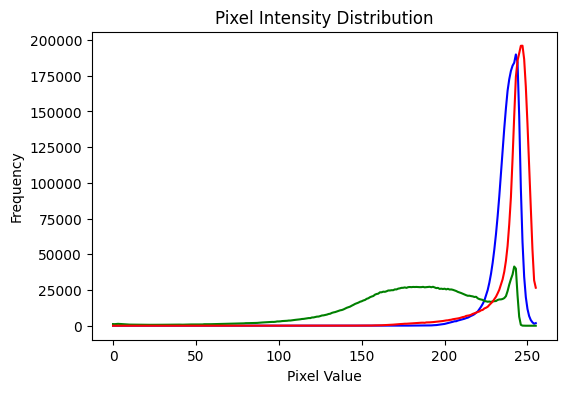

In [ ]:
def plot_intensity_histogram(img_path):
    img = cv2.imread(img_path)
    color = ('b', 'g', 'r')
    plt.figure(figsize=(6, 4))
    for i, col in enumerate(color):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()

# Try with one image
sample_path = os.path.join(data_dir, 'HCC', os.listdir(os.path.join(data_dir, 'HCC'))[0])
plot_intensity_histogram(sample_path)


#🔹 5. Color Mean & Standard Deviation (Per Class)
Compare brightness/contrast between different classes.

In [ ]:
import numpy as np

def compute_color_stats_per_class(data_dir):
    stats = {}
    for cls in os.listdir(data_dir):
        img_paths = [os.path.join(data_dir, cls, img) for img in os.listdir(os.path.join(data_dir, cls))]
        means, stds = [], []
        for path in img_paths:
            img = cv2.imread(path)
            img = img.astype('float32') / 255.0
            means.append(np.mean(img, axis=(0, 1)))
            stds.append(np.std(img, axis=(0, 1)))
        stats[cls] = {
            "Mean": np.mean(means, axis=0),
            "Std Dev": np.mean(stds, axis=0)
        }
    return stats

stats = compute_color_stats_per_class("processed_dataset")
for cls, val in stats.items():
    print(f"\n📁 Class: {cls}")
    print(f"🔹 Mean RGB: {val['Mean']}")
    print(f"🔹 Std Dev RGB: {val['Std Dev']}")



📁 Class: HCC
🔹 Mean RGB: [0.77074707 0.53275675 0.7719087 ]
🔹 Std Dev RGB: [0.19475166 0.23538204 0.21452984]

📁 Class: CC
🔹 Mean RGB: [0.7173819  0.5339946  0.72312874]
🔹 Std Dev RGB: [0.19179647 0.21340536 0.20211734]

📁 Class: NORMAL LIVER
🔹 Mean RGB: [0.67042655 0.44038722 0.69617397]
🔹 Std Dev RGB: [0.19050136 0.18934241 0.20007013]


# 📂 Optional: Export Summary Report

You can also write all stats to a CSV or TXT file if needed.

In [ ]:
with open("eda_summary.txt", "w") as f:
    for cls, val in stats.items():
        f.write(f"Class: {cls}\n")
        f.write(f"Mean RGB: {val['Mean']}\n")
        f.write(f"Std Dev RGB: {val['Std Dev']}\n\n")


(1)    **EDA**

✅ **(1) Load Dataset**

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy import stats

# Path to dataset folder
data_dir = '/content/drive/MyDrive/PROJECT/LIVER DAMAGE DETECTION/DataSet'

classes = os.listdir(data_dir)

# Create a dataframe to store metadata
image_data = []

for label in classes:
    class_dir = os.path.join(data_dir, label)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                img_array = np.array(img.convert('L'))  # Convert to grayscale
                intensity_flat = img_array.flatten()
                mean_intensity = intensity_flat.mean()
                median_intensity = np.median(intensity_flat)
                mode_intensity = stats.mode(intensity_flat, axis=None, keepdims=False).mode
                aspect_ratio = width / height
                image_data.append([
                    img_file, label, width, height, aspect_ratio,
                    mean_intensity, median_intensity, mode_intensity
                ])
        except:
            print(f"Skipping corrupted image: {img_path}")

# Create DataFrame
df = pd.DataFrame(image_data, columns=[
    'Filename', 'Class', 'Width', 'Height', 'Aspect_Ratio',
    'Mean_Intensity', 'Median_Intensity', 'Mode_Intensity'
])

df.head()


,Filename,Class,Width,Height,Aspect_Ratio,Mean_Intensity,Median_Intensity,Mode_Intensity
0,140_filtered.jpg,CC,1539,916,1.680131,184.236458,186.0,201
1,71_shifted.jpg,CC,1600,1138,1.405975,180.760548,194.0,0
2,108_shifted.jpg,CC,685,451,1.518847,136.107197,153.0,0
3,108_filtered.jpg,CC,685,451,1.518847,152.201088,158.0,171
4,81_shifted.jpg,CC,2448,1920,1.275000,146.381626,152.0,0


**✅ (2) EDA for Each Class**

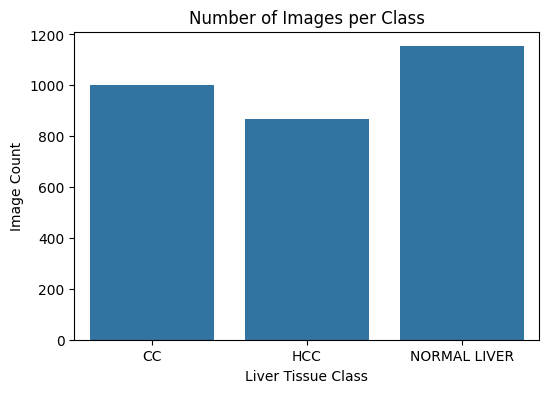

In [ ]:
# Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Class')
plt.title('Number of Images per Class')
plt.xlabel('Liver Tissue Class')
plt.ylabel('Image Count')
plt.show()


In [ ]:
# Step 3: Undersample majority classes
# Get the minimum count of samples per class
min_count = df['Class'].value_counts().min()

# Undersample to balance the dataset
balanced_df = pd.concat([
    df[df['Class'] == cls].sample(min_count, random_state=42)
    for cls in df['Class'].unique()
])

In [ ]:
# Check Balanced or Not
import os
import shutil
import random
from pathlib import Path

# Path to your original dataset
dataset_path = Path('/content/drive/MyDrive/PROJECT/LIVER DAMAGE DETECTION/DataSet')  # change if needed

# Count files in each class
class_counts = {folder.name: len(list(folder.glob('*'))) for folder in dataset_path.iterdir() if folder.is_dir()}
print("📊 Class Distribution BEFORE balancing:\n", class_counts)

# Get minimum count for balancing
min_count = min(class_counts.values())
print(f"\n⚖️ Balancing all classes to {min_count} samples...")

# Output path for balanced data
balanced_path = Path('/content/balanced_dataset')
shutil.rmtree(balanced_path, ignore_errors=True)
balanced_path.mkdir(parents=True, exist_ok=True)

# Undersample and copy files
for class_name, count in class_counts.items():
    class_dir = dataset_path / class_name
    balanced_class_dir = balanced_path / class_name
    balanced_class_dir.mkdir(parents=True, exist_ok=True)

    # Randomly select min_count files
    selected_files = random.sample(list(class_dir.glob('*')), min_count)

    for file_path in selected_files:
        shutil.copy(file_path, balanced_class_dir)

# Check new class distribution
new_counts = {folder.name: len(list(folder.glob('*'))) for folder in balanced_path.iterdir() if folder.is_dir()}
print("\n✅ Class Distribution AFTER balancing:\n", new_counts)


📊 Class Distribution BEFORE balancing:
 {'CC': 1000, 'HCC': 869, 'NORMAL LIVER': 1153}

⚖️ Balancing all classes to 869 samples...

✅ Class Distribution AFTER balancing:
 {'CC': 869, 'HCC': 869, 'NORMAL LIVER': 869}


**Download the balanced dataset as ZIP**

In [ ]:
# Zip the balanced folder
shutil.make_archive('balanced_dataset', 'zip', '/content/balanced_dataset')

# Download the zip file
from google.colab import files
files.download('balanced_dataset.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil # Import the shutil module to access the copy function
import os
# Optional: Save balanced dataset to new folders
balanced_dir = 'balanced_dataset'
if not os.path.exists(balanced_dir):
    os.makedirs(balanced_dir)

for cls in classes:
    os.makedirs(os.path.join(balanced_dir, cls), exist_ok=True)

for _, row in balanced_df.iterrows():
    # Assuming your DataFrame has a column named 'Filename' or 'Path'
    # that contains the path to the source image file.
    # Replace 'Filename' with the actual column name if it's different.
    # This section was unindented. Indenting fixes the error.
    source_path = row.get('Path', row['Filename'])  # Try 'Path' first, fallback to 'Filename'
    dest_path = os.path.join(balanced_dir, row['Class'], os.path.basename(source_path))
    #copyfile(source_path, dest_path) # Assuming 'copyfile' is imported.

**✅ (3) Intensity Distribution**

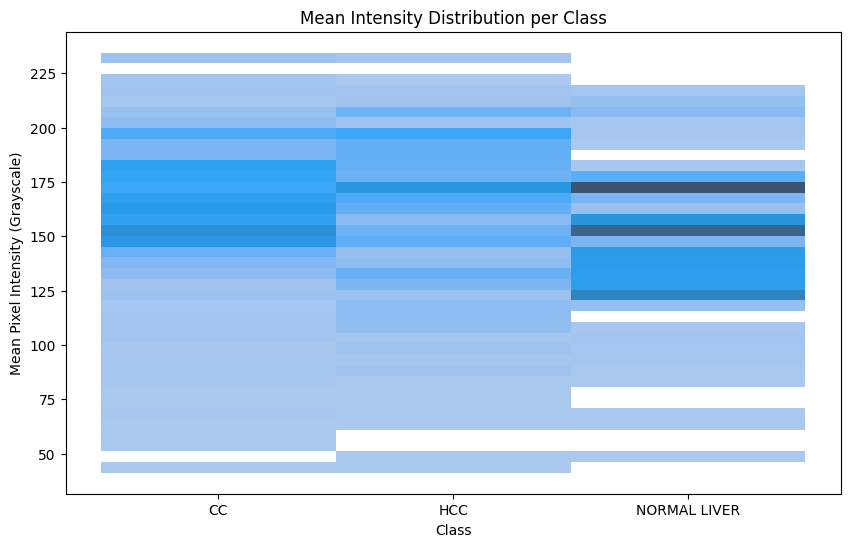

In [ ]:
# Intensity distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Class', y='Mean_Intensity')
plt.title('Mean Intensity Distribution per Class')
plt.xlabel('Class')
plt.ylabel('Mean Pixel Intensity (Grayscale)')
plt.show()


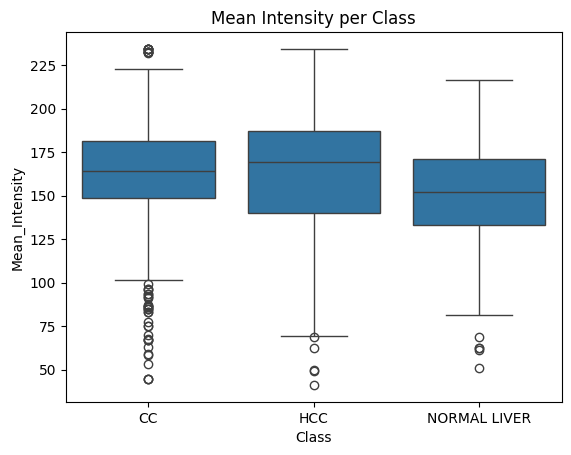

In [ ]:
# 1. Boxplot of intensities per class
sns.boxplot(x='Class', y='Mean_Intensity', data=df)
plt.title('Mean Intensity per Class')
plt.show()

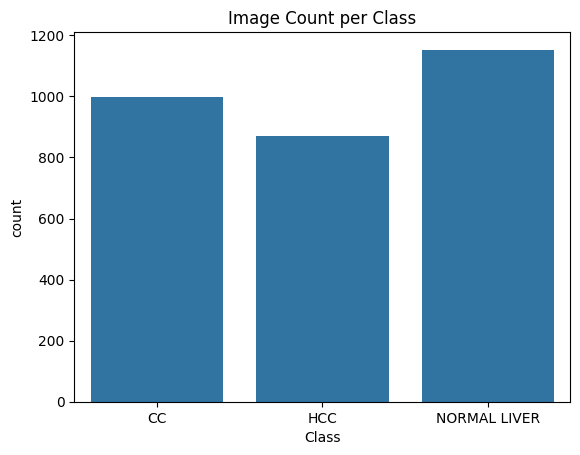

In [ ]:
# 2. Class distribution
sns.countplot(x='Class', data=df)
plt.title('Image Count per Class')
plt.show()

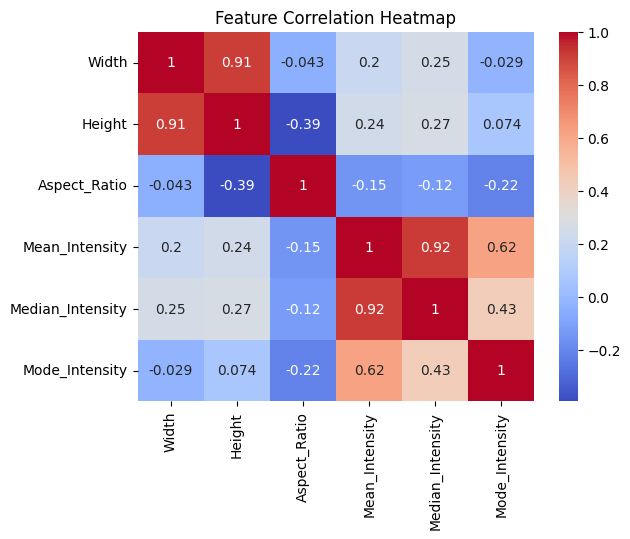

In [ ]:
# 3. Correlation heatmap
sns.heatmap(df[['Width', 'Height', 'Aspect_Ratio', 'Mean_Intensity', 'Median_Intensity', 'Mode_Intensity']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

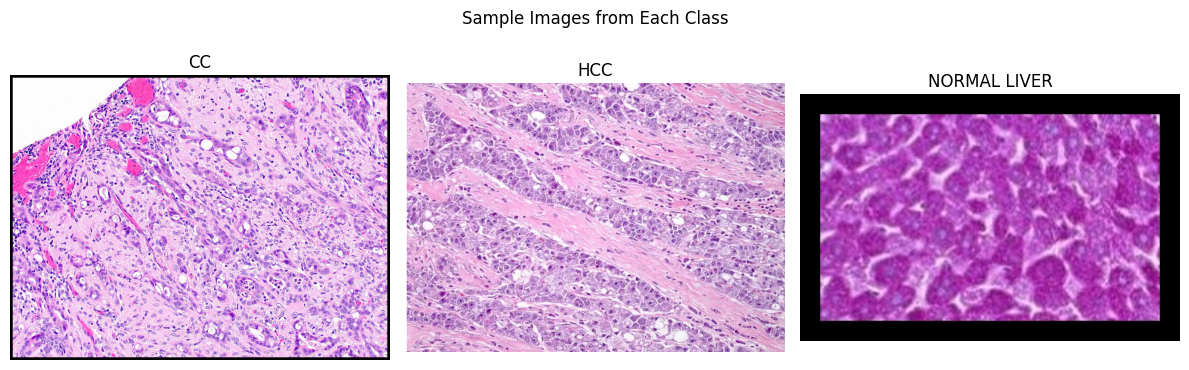

In [ ]:
# 4. Grid of images per class
import random
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, label in enumerate(df['Class'].unique()):
    sample_file = random.choice(df[df['Class'] == label]['Filename'].values)
    path = os.path.join(data_dir, label, sample_file)
    img = Image.open(path)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis('off')
plt.suptitle("Sample Images from Each Class")
plt.tight_layout()
plt.show()

**✅ (4) Aspect Ratio & Insights**

📐 Why Check Aspect Ratio in Image Datasets?

⚠️ 1. Aspect Ratio Impacts Model Performance
Aspect ratio = Width / Height of the image.

If images across classes have very different shapes, your model might learn shape/size patterns instead of real features (e.g., tissue structures).

For example, if HCC images are mostly wide and Normal are tall, your model might cheat and learn that instead of learning actual liver cell patterns. That's called data leakage or bias.

📊 2. Quality Check & Preprocessing
By plotting the aspect ratio (as you did with a violin plot), you're checking:

Are all images consistently shaped?

Are there outliers (very stretched or squished images)?

This helps you standardize image dimensions, like resizing to (224x224) or padding images without distorting them.

🔍 3. Violin Plot Insight
Your sns.violinplot() shows how the distribution of aspect ratios varies across HCC, CC, and Normal Liver.

If distributions are very different, you may consider:

Resizing all images while maintaining aspect ratio (with padding)

Or forcing a fixed aspect ratio (may lose detail)

✨ BONUS: Why You Also Checked Mean Intensity
Mean intensity gives an idea of brightness or tissue density.

Variations here can show differences in staining, scanner settings, or cell structure—useful for further feature engineering.

✅ In Short:
You checked aspect ratio to ensure image shape consistency, avoid biases or shortcuts in model learning, and to improve model generalization.

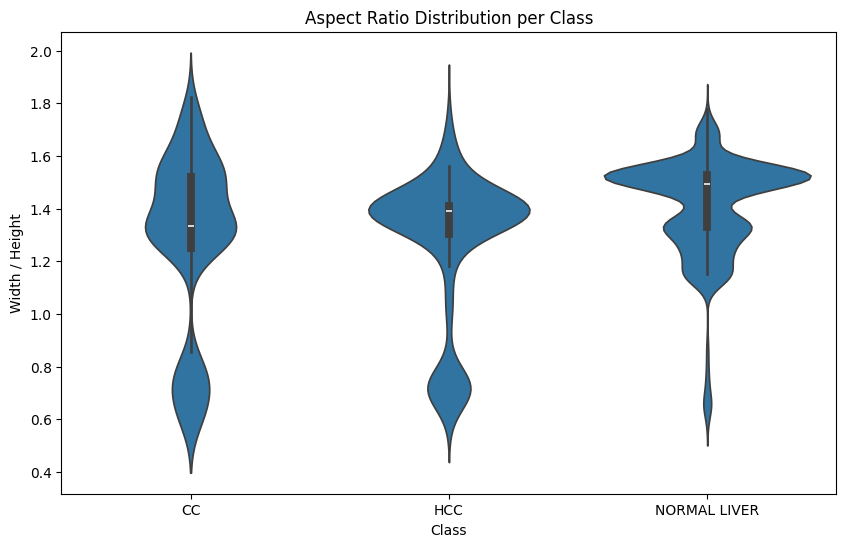

Aspect Ratio Summary:
               count      mean       std       min       25%       50%  \
Class                                                                    
CC            1000.0  1.281041  0.333528  0.564545  1.250000  1.333333   
HCC            869.0  1.273752  0.278023  0.580981  1.303538  1.391863   
NORMAL LIVER  1153.0  1.407053  0.189762  0.593190  1.328990  1.494643   

                   75%       max  
Class                             
CC            1.518847  1.824441  
HCC           1.409091  1.803419  
NORMAL LIVER  1.527273  1.780069  

Mean Intensity Summary:
               count        mean        std        min         25%  \
Class                                                                
CC            1000.0  163.186690  28.815529  44.478165  148.599836   
HCC            869.0  162.061795  32.619215  41.188258  139.933333   
NORMAL LIVER  1153.0  151.045482  23.900881  50.993930  133.097453   

                     50%         75%         max  
Class

In [ ]:
# Aspect Ratio Distribution
plt.figure(figsize=(10,6))
sns.violinplot(data=df, x='Class', y='Aspect_Ratio', inner='box')
plt.title('Aspect Ratio Distribution per Class')
plt.xlabel('Class')
plt.ylabel('Width / Height')
plt.show()

# Insights
print("Aspect Ratio Summary:")
print(df.groupby('Class')['Aspect_Ratio'].describe())

print("\nMean Intensity Summary:")
print(df.groupby('Class')['Mean_Intensity'].describe())


**✅ (5) Parameters For Analysis**

💡 Parameters Used in Histopathology EDA Parameter	Description

Width & Height	Dimensions of each image

Aspect Ratio	Width / Height, used to analyze resizing needs

Mean Intensity	Average grayscale intensity per image

Class	Label/category of image

Pixel Stats	Mean and StdDev of intensity and aspect ratio

In [ ]:
summary_stats = df.groupby('Class').agg({
    'Width': ['mean', 'std'],
    'Height': ['mean', 'std'],
    'Aspect_Ratio': ['mean', 'std'],
    'Mean_Intensity': ['mean', 'std']
}).round(2)

summary_stats.columns = ['_'.join(col) for col in summary_stats.columns]
summary_stats.reset_index(inplace=True)
print(summary_stats)


          Class  Width_mean  Width_std  Height_mean  Height_std  \
0            CC     1231.33     692.12      1013.42      601.98   
1           HCC      901.55     478.73       736.14      409.65   
2  NORMAL LIVER      459.75     221.67       340.15      192.21   

   Aspect_Ratio_mean  Aspect_Ratio_std  Mean_Intensity_mean  \
0               1.28              0.33               163.19   
1               1.27              0.28               162.06   
2               1.41              0.19               151.05   

   Mean_Intensity_std  
0               28.82  
1               32.62  
2               23.90  


**🔍 Additional Visualization (Optional)**

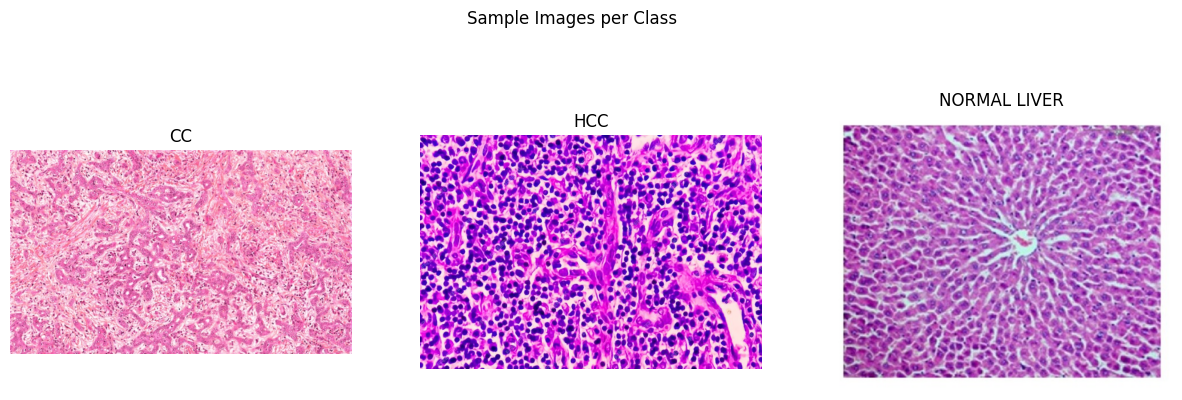

In [ ]:
# Sample images per class
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, label in zip(axes, classes):
    class_dir = os.path.join(data_dir, label)
    sample_image = os.listdir(class_dir)[0]
    img_path = os.path.join(class_dir, sample_image)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
plt.suptitle("Sample Images per Class")
plt.show()


---------------  **IMPORTING NECESSARY LIBRARIES**  -----------

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch
from zipfile import ZipFile # Import ZipFile for creating zip archives
import shutil # Import the shutil module
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
# The following line was indented but should not have been
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

-------------------------  **Data Preprocessing Steps**  -----------------------

In [ ]:
# -------- Configuration --------
input_dir = "/content/balanced_dataset"  # 🔁 Replace with balance dataset directory (containing HCC, CC, NORMAL LIVER)
output_dir = "processed_dataset"

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tqdm import tqdm

# -------- Configuration --------
input_dir = "/content/drive/MyDrive/PROJECT/LIVER DAMAGE DETECTION/balanced_dataset"  # Make sure this has 869 images per class
output_dir = "processed_dataset"
os.makedirs(output_dir, exist_ok=True)

classes = os.listdir(input_dir)
for cls in classes:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

# -------- Data Augmentation Config (just 1 variant) --------
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# -------- Process Each Image --------
for cls in classes:
    class_path = os.path.join(input_dir, cls)
    save_path = os.path.join(output_dir, cls)

    for img_name in tqdm(os.listdir(class_path), desc=f"Processing {cls}"):
        img_path = os.path.join(class_path, img_name)

        # Step 1: Load image
        img = cv2.imread(img_path)
        if img is None:
            continue  # skip unreadable images
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Step 2: Save Original
        base_filename = os.path.splitext(img_name)[0]
        cv2.imwrite(os.path.join(save_path, f"{base_filename}_original.jpg"), img)

        # Step 3: Augment (only 1 variant)
        img_array = img_to_array(img_rgb) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        aug_iter = datagen.flow(img_array, batch_size=1)
        aug_image = next(aug_iter)[0]  # shape: (H, W, 3), scaled between 0-1
        aug_image_uint8 = (aug_image * 255).astype("uint8")

        # Step 4: Save augmented
        cv2.imwrite(os.path.join(save_path, f"{base_filename}_augmented.jpg"), cv2.cvtColor(aug_image_uint8, cv2.COLOR_RGB2BGR))

print("✅ All images processed and saved with only 1 augmentation per original.")


Processing NORMAL LIVER: 100%|██████████| 869/869 [01:19<00:00, 10.87it/s]

✅ All images processed and saved with only 1 augmentation per original.


In [ ]:
import os
# Path to the processed dataset
processed_dir = "/content/processed_dataset"

# Dictionary to hold class-wise image counts
class_counts = {}

# Count images in each class folder
for cls in os.listdir(processed_dir):
    class_path = os.path.join(processed_dir, cls)
    if os.path.isdir(class_path):
        image_count = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))])
        class_counts[cls] = image_count

# Display class-wise counts
print("📦 Processed Image Counts per Class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

# Total images
total_images = sum(class_counts.values())
print(f"\n🧮 Total Processed Images: {total_images}")


📦 Processed Image Counts per Class:
CC: 8690 images
HCC: 8690 images
NORMAL LIVER: 8690 images

🧮 Total Processed Images: 26070


In [ ]:
import shutil

# Zip the folder
shutil.make_archive("processed_dataset", 'zip', "processed_dataset")


'/content/processed_dataset.zip'